# Исследование надёжности заёмщиков
<a id="top"></a>

<h4 align="right">Артур Урусов</h4>

> Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
>
>Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Содержание

0. [Подготовка](#0)

    0.1. [Импорт библиотек](#0-1)
    
    0.2. [Проверка версий](#0-2)


1. [Получение данных](#1)

    1.1. [Чтение файла](#1-1) 
    
    1.2. [Выводы по первому этапу](#1-2)


2. [Предобработка данных](#2)

    2.1. [Заголовки и дубликаты](#2-1)
    
    2.2. [Пропущенные значения](#2-2)
    
    2.3. [Аномальные значения](#2-3)
    
    2.4. [Изменение типа данных](#2-4)
    
    2.5. [Лемматизация данных](#2-5)
    
    2.6. [Категорирование данных](#2-6)
    
    2.7. [Выводы по второму этапу](#2-7)


3. [Проверка гипотез](#3)

    3.1. [Как влияет наличие детей на возврат кредита в срок?](#3-1)
    
    3.2. [С какой веротностью вернут кредит в срок клиенты с разным семейным положением?](#3-2)
    
    3.3. [Кто вероятнее расплатится в срок - бедный или богатый?](#3-3)
    
    3.4. [Свадьба или образование? Автомобиль или недвижимость? Где риски невозврата кредита выше?](#3-4)


4. [Результаты исследования](#4)

    4.1. [Общие выводы](#4-1)

[к началу страницы](#top)

## Этап 0. Подготовка
<a id="0"></a>

### 0.1 Импорт библиотек
<a id="0-1"></a>

In [1]:
# импортируем необходимые библиотеки и функции
import platform
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pymystem3 import Mystem
from collections import Counter
m = Mystem() # присваиваем переменной m функцию Mystem

### 0.2 Проверка версий
<a id="0-2"></a>

Проект гарантированно работает с Python версии `3.7.6` и библиотекой Pandas версии `0.25.1`

In [2]:
print('Python ' + platform.python_version()) # версия Python
print('Pandas ' + pd.__version__)            # версия Pandas

Python 3.7.6
Pandas 0.25.1


[к началу раздела](#0) | [к началу страницы](#top)

## Этап 1. Получение данных
<a id="1"></a>

### 1.1 Чтение файла
<a id="1-1"></a>

Прочитаем файл */datasets/data.csv* и сохраним его в переменной `df`:

In [3]:
if platform.system() == 'Windows':
    # прочитаем файл с данными и сохраним в df (Windows)
    df = pd.read_csv('datasets\data.csv')
else:
    # прочитаем файл с данными с сохраним в df (UNIX-like)
    df = pd.read_csv('/datasets/data.csv')

Получим общую информацию о таблице:

In [4]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Выведем первые 10 строк таблицы:

In [5]:
df.head(10) # выведем первые 10 строк таблицы df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Теперь рассмотрим наши данные.

Всего в таблице **11** столбцов, типы данных - *float64* (2), *int64* (5), *object* (5).

Исходя из вводных данных в столбцах находится следующая информация:
- `children` — количество детей в семье;
- `days_employed` — общий трудовой стаж в днях;
- `dob_years` — возраст клиента в годах;
- `education` — уровень образования клиента;
- `education_id` — идентификатор уровня образования;
- `family_status` — семейное положение;
- `family_status_id` — идентификатор семейного положения;
- `gender` — пол клиента;
- `income_type` — тип занятости;
- `debt` — имел ли задолженность по возврату кредитов;
- `total_income` — ежемесячный доход;
- `purpose` — цель получения кредита.

Всего строк **21525**, однако в столбцах `days_employed` и `total_income` по **19351** значений. Это говорит о том, что *во-первых*, в этих столбцах присутсвуют пропущенные значения, а *во-вторых*, что у отстутствия этих значений может быть общая причина.

### 1.2 Выводы по первому этапу
<a id="1-2"></a>

Каждая строка таблицы содержит информацию по отдельному клиенту банка, который обращался за кредитом. С точки зрения поставленной задачи, в первую очередь нас будут интересовать столбцы `children` и `family_status`, однако и в других столбцах может скрываться интересующая нас информация. Для начала нужно разобраться со следующими проблемами в данных: поправить названия столбцов, исследовать и отработать пропущенные значения, привести типы значений к единому формату *(например в столбце `education`)*, а так же вынести их в словари, разобраться с отрицательными значениями в столбце `days_employed` и привести тип данных в столбцах к подходящему.

[к началу раздела](#1) | [к началу страницы](#top)

## Этап 2. Предобработка данных
<a id="2"></a>

### 2.1 Заголовки и дубликаты
<a id="2-1"></a>

Для начала обработаем названия столбцов нашей таблицы.

In [6]:
df.columns # выведем названия столбцов

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

Видим, что с точки зрения формата проблем нет: названия столбцов написаны в нижнем регистре, с подчёркиваниями вместо пробелов, лишних пробелов или иных символов нет. Однако, названия столбцов не совсем корректно отображают их содержание, поэтому заменим их:

In [7]:
# переименуем столбцы
df.set_axis(['number_of_children', 'days_employed', 'age_in_years', 
             'education_level', 'education_level_id', 
             'family_status', 'family_status_id', 'sex', 
             'employment_type', 'failed_to_pay_debt', 'monthly_income', 
             'credit_purpose'], axis = 'columns', inplace = True)

Проверим, успешно ли прошло переименование:

In [8]:
df.columns # еще раз выведем названия столбцов

Index(['number_of_children', 'days_employed', 'age_in_years',
       'education_level', 'education_level_id', 'family_status',
       'family_status_id', 'sex', 'employment_type', 'failed_to_pay_debt',
       'monthly_income', 'credit_purpose'],
      dtype='object')

Теперь заголовки столбцов в таблице выглядят так:
- `number_of_children` — количество детей в семье;
- `days_employed` — общий трудовой стаж в днях;
- `age_in_years`  — возраст клиента в годах;
- `education_level`  — уровень образования клиента;
- `education_level_id` — идентификатор уровня образования;
- `family_status` — семейное положение;
- `family_status_id` — идентификатор семейного положения;
- `sex` — пол клиента;
- `employment_type` — тип занятости;
- `failed_to_pay_debt` — имел ли задолженность по возврату кредитов;
- `monthly_income` — ежемесячный доход;
- `credit_purpose` — цель получения кредита.

Кроме того, перед обработкой остальных данных, приведем все столбцы с типом object (`education_level`, `family_status`, `sex`, `employment_type` и `credit_purpose`) к нижнему регистру:

In [9]:
# приводим столбцы к нижнему регистру
df['education_level'] = df['education_level'].str.lower()
df['family_status'] = df['family_status'].str.lower()
df['sex'] = df['sex'].str.lower()
df['employment_type'] = df['employment_type'].str.lower()
df['credit_purpose'] = df['credit_purpose'].str.lower()

### 2.2 Пропущенные значения
<a id="2-2"></a>

Проверим наличие пропущенных значений в таблице:

In [10]:
df.isnull().sum() # считаем все пропущенные значения

number_of_children       0
days_employed         2174
age_in_years             0
education_level          0
education_level_id       0
family_status            0
family_status_id         0
sex                      0
employment_type          0
failed_to_pay_debt       0
monthly_income        2174
credit_purpose           0
dtype: int64

Как видим, значения пропущены в столбцах `days_employed` и `monthly_income`. Проверим, связаны ли эти пропуски между собой:

In [11]:
# Ищем такие строки в таблице, 
# чтобы И в столбце days_employed И в столбце monthly_income 
# были пропущенные значения
df[(df['days_employed'].isnull() == True) & 
   (df['monthly_income'].isnull() == True)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
number_of_children    2174 non-null int64
days_employed         0 non-null float64
age_in_years          2174 non-null int64
education_level       2174 non-null object
education_level_id    2174 non-null int64
family_status         2174 non-null object
family_status_id      2174 non-null int64
sex                   2174 non-null object
employment_type       2174 non-null object
failed_to_pay_debt    2174 non-null int64
monthly_income        0 non-null float64
credit_purpose        2174 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Получился DataFrame с **2174** строками. Столько же пропущенных значений в каждом из столбцов `days_employed` и `monthly_income` в оригинальной таблице. То есть, значения в этих столбцах отсутствуют попарно, а строк с отсутвующим значением только в одном из столбцов **нет**. Таким образом, наиболее правдоподобной будет версия, что пропуски в этих значениях имеют общее происхождение.

In [12]:
# выведем первые 10 строк с пропущенными значениями на экран
df[df.isnull().any(axis = 1)].head(10)

,number_of_children,days_employed,age_in_years,education_level,education_level_id,family_status,family_status_id,sex,employment_type,failed_to_pay_debt,monthly_income,credit_purpose
12,0,NaN,65,среднее,1,гражданский брак,1,m,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,m,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,не женат / не замужем,4,f,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,f,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,f,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,не женат / не замужем,4,m,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,f,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,m,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,f,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,m,сотрудник,0,NaN,жилье


При этом, как видно даже из первых 10 строк таблицы, зависимости пропусков от других значений не наблюдается. Все остальные столбцы наполнены разнообразной информацией. Таким образом, эти пропуски случайны. Скорее всего их появление связано с технической неисправностью или с ошибкой оператора базы данных, при этом возможно их появление зависит от какого-то другого параметра, не указанного в этой таблице.

Теперь заполним пустые значения. Для начала разберемся с ежемесячным доходом (столбец `monthly_income`). Предполагаем, что средний доход за месяц зависит от *пола*, *уровня образования* и *типа занятости*:

In [13]:
# применяем к таблице алгоритм заполнения пропущенных значений медианой
# по группам с одинаковым полом, уровнем образования и типом занятости
for row in df.itertuples(name = None):
    if row[11] != row[11]:
        df.loc[(df['sex'] == row[8]) & (df['education_level_id'] == row[5]) & (df['employment_type'] == row[9]) & (df['monthly_income'].isnull() == True), 'monthly_income'] = df[(df['sex'] == row[8]) & (df['education_level_id'] == row[5]) & (df['employment_type'] == row[9])]['monthly_income'].median()

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Далее проверим заполнение значений:

In [14]:
df.isnull().sum() # снова посчитаем все пропущенные значения

number_of_children       0
days_employed         2174
age_in_years             0
education_level          0
education_level_id       0
family_status            0
family_status_id         0
sex                      0
employment_type          0
failed_to_pay_debt       0
monthly_income           1
credit_purpose           0
dtype: int64

Одна строка всё еще пустая. Почему? Попробуем разобраться - выведем эту строку на экран:

In [15]:
# выведем на экран строку с пропущенным значением
df[df['monthly_income'].isnull()]

,number_of_children,days_employed,age_in_years,education_level,education_level_id,family_status,family_status_id,sex,employment_type,failed_to_pay_debt,monthly_income,credit_purpose
5936,0,NaN,58,высшее,0,женат / замужем,0,m,предприниматель,0,NaN,покупка жилой недвижимости


Очевидно, что мужчины с высшим образованием в таблице встречаются, значит нам попался уникальный предприниматель. Посмотрим встречаются ли ещё предприниматели в таблице:

In [16]:
# выведем на экран всех предпринимателей
df[df['employment_type'] == 'предприниматель']

,number_of_children,days_employed,age_in_years,education_level,education_level_id,family_status,family_status_id,sex,employment_type,failed_to_pay_debt,monthly_income,credit_purpose
5936,0,NaN,58,высшее,0,женат / замужем,0,m,предприниматель,0,NaN,покупка жилой недвижимости
18697,0,-520.848083,27,высшее,0,гражданский брак,1,f,предприниматель,0,499163.144947,на проведение свадьбы


Всего два предпринимателя на **21525** строк! К сожалению, применение любого метода заполнения приведет к значительному искажению информации по категории *предприниматели*, поэтому пропущенное значение лучше не заполнять. Однако, и удаление строчки тоже не лучший вариант, так мы потеряем значения по другим столбцам. Поэтому, пожалуй, наиболее адекватным вариантом будет оставить эту строчку как есть.

Теперь приступим к заполнению пропущенных значений в столбце `days_employed`. Мы можем просто приравнять пропущенные значения в этом столбце к нулю, но можем и подумать ещё 🤔.

Поэтому попробуем другой вариант. Напишем функцию, которая подставляет стаж в незаполненные строки. Средним значением возьмём половину стажа для конкретного возраста с учетом непрерывной работы с 18 лет. Воспользуемся правилом 3 сигм: наши значения в подавляющем большинстве случаев не должны превысить допустимые, значит 3σ будет равно разницей между Максимальным значением стажа и средним. Отсюда найдём σ, разделив эту разницу на 3.

In [17]:
# функция для заполнения случайными значениями на основе распределения Гаусса
def autogauss(df):
    if df['days_employed'] != df['days_employed']:
        mn = (df['age_in_years'] - 18) * 365 / 2
        sigma = mn / 3
        return random.gauss(mn, sigma) * -1
    else:
        return df['days_employed']

In [18]:
# применяем функцию к таблице
df['days_employed'] = df.apply(autogauss, axis=1)

Проверим, получилось ли заполнить пропущенные значения:

In [19]:
df.isnull().sum() # и ещё раз подсчитаем количество пропущенных значений

number_of_children    0
days_employed         0
age_in_years          0
education_level       0
education_level_id    0
family_status         0
family_status_id      0
sex                   0
employment_type       0
failed_to_pay_debt    0
monthly_income        1
credit_purpose        0
dtype: int64

На этом этапе мы завершили обработку пропущенных значений. Однако есть еще несколько моментов, требующих нашего внимания.

[к началу страницы](#top)

### 2.3 Аномальные значения
<a id="2-3"></a>

Кроме собственно пропущенных, *пустых* значений, в таблице присутствуют и *аномальные* значения, которые противоречат здравому смыслу и выглядят выбивающимися из общей картины (отрицательное или большое количество детей, отрицательный или слишком большой трудовой стаж).

Возьмём, например, количество детей (столбец `number_of_children`):

In [20]:
# создадим сводную таблицу и разделим на промежутки
df['groups'] = pd.cut(df['number_of_children'],[-999,-1,0,5,999])
# посчитаем количество значений и среднее по указанным промежуткам
df.groupby('groups')['number_of_children'].agg(['count','mean'])

,count,mean
groups,,
"(-999, -1]",47,-1.00000
"(-1, 0]",14149,0.00000
"(0, 5]",7253,1.39625
"(5, 999]",76,20.00000


Видно, что подавляющее большинство значений находятся в рамках разумного, однако в **47** случаях количество детей отрицательное (при этом ровно *-1*), а в **76** случаях - ровно 20. Уберём эти аномалии и приравняем оба этих значения к нулю.

In [21]:
# заменим значения ниже нуля на ноль
df.loc[(df['number_of_children'] < 0), 'number_of_children'] = 0
# заменим значения равные 20 на ноль
df.loc[(df['number_of_children'] == 20), 'number_of_children'] = 0

Снова проверим распределение значений:

In [22]:
# создадим сводную таблицу и разделим на промежутки
df['groups'] = pd.cut(df['number_of_children'],[-999,-1,0,5,999])
# посчитаем количество значений и среднее по указанным промежуткам
df.groupby('groups')['number_of_children'].agg(['count','mean'])

,count,mean
groups,,
"(-999, -1]",0,NaN
"(-1, 0]",14272,0.00000
"(0, 5]",7253,1.39625
"(5, 999]",0,NaN


Мы преобразовали аномальные значения, и теперь распределение выглядит адекватно.

Возьмём следующий столбец `days_employed`:

In [23]:
# создадим сводную таблицу и разделим на промежутки
df['groups'] = pd.cut(df['days_employed'],[-999999,-1,0,999999])
# посчитаем количество значений и среднее по указанным промежуткам
#df.groupby('groups')['days_employed'].agg(['count','mean','median','min','max'])
df.groupby('groups')['age_in_years'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
groups,,,,,
"(-999999, -1]",18067,40.299828,40.0,0.0,75.0
"(-1, 0]",0,NaN,NaN,NaN,NaN
"(0, 999999]",3458,58.933777,60.0,0.0,74.0


Также взглянем на гистограмму:

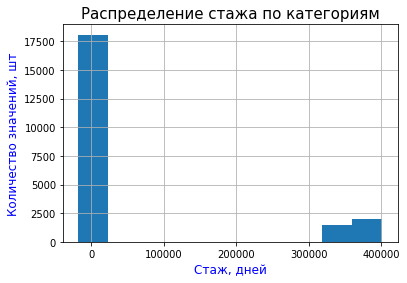

In [24]:
df['days_employed'].hist() # построим гистограмму
plt.title('Распределение стажа по категориям', fontsize=15)
plt.xlabel('Стаж, дней', fontsize=12, color='blue')
plt.ylabel('Количество значений, шт', fontsize=12, color='blue')
plt.grid(True)

Видим ещё одно аномальное распределение. Подавляющее большинство значений находятся в промежутке от **-19000** до **0**, но при этом **3445** значения оказались положительными и на порядок больше по модулю. Допустим, что действительный стаж оказался по каким-то причинам отрицательным числом.

Возьмём самое большое по модулю значение из первой группы:

In [25]:
18388.949901 / 365 # переведем дни в годы

50.38068466027397

Стаж в **50** лет кажется значительным, но при этом допустимым. Всё-таки это наибольшее по модулю число в этой группе.

Теперь посмотрим на наименьшее число из второй группы:

In [26]:
328728.720605 / 365 # переведем дни в годы

900.6266317945204

**900** лет! Это определённо нечеловеческий стаж. Значения из второй группы явным образом аномальны, поэтому первоначальной идеей было приведение их к нулевому значению. Однако, если покопаться глубже, то можно обнаружить, что для людей определённого возраста и меньше значения отрицательные, но по модулю приемлемые, а для людей старше этого возраста значения очень большие, можно предположить, что большие значения представлены в часах, если их привести к годам, то все будет ок, поэтому сделаем немного по-другому.

Проверим:

In [27]:
328728.720605 / (24*365) # переведём в часы в годы

37.52610965810502

Действительно, получается намного более правдиво. Теперь это можно назвать стажем. Получается, этих людей записывали в другом формате &mdash; возможно это устаревший формат, либо данные некорректно перенесены из другой системы. Напишем функцию, преобазующую стаж в нормальный формат:

In [28]:
# функция для перевода значений из часов в дни
def hours_to_days(df):
    if df['days_employed'] > 0:
        return df['days_employed'] / -24
    else:
        return df['days_employed']

Предварительно посмотрим как значения распределены на графике:

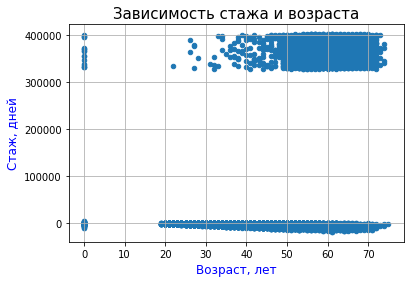

In [29]:
# строим scatter-график
df.plot.scatter(x='age_in_years', y='days_employed')
plt.title('Зависимость стажа и возраста', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12, color='blue')
plt.ylabel('Стаж, дней', fontsize=12, color='blue')
plt.grid(True)

Теперь применим её к таблице:

In [30]:
# применяем функцию к таблице
df['days_employed'] = df.apply(hours_to_days, axis=1)

Посмотрим, как изменился наш график:

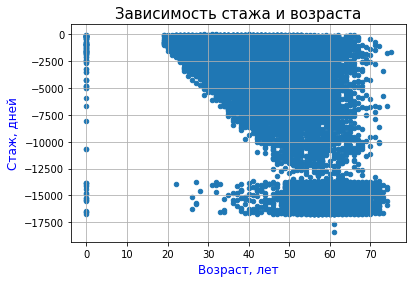

In [31]:
# строим scatter-график
df.plot.scatter(x='age_in_years', y='days_employed')
plt.title('Зависимость стажа и возраста', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12, color='blue')
plt.ylabel('Стаж, дней', fontsize=12, color='blue')
plt.grid(True)

Видим, что у нас есть две группы значений, которые сильно выбиваются из общего ряда. Для начала раберёмся с той группой, где возраст равен нулю. Изначально мы проставляли возраст по медиане соответствующего типа занятости. В этот раз попробуем использовать стаж для предположения возраста. Посмотрим коэффициенты корреляции:

In [32]:
# вызываем таблицу с коэффициентами корреляции
df.corr()

,number_of_children,days_employed,age_in_years,education_level_id,family_status_id,failed_to_pay_debt,monthly_income
number_of_children,1.000000,0.239070,-0.310068,-0.027572,-0.157682,0.024951,0.033421
days_employed,0.239070,1.000000,-0.636058,-0.068826,0.023330,0.067546,0.117393
age_in_years,-0.310068,-0.636058,1.000000,0.067467,-0.069988,-0.069620,-0.060361
education_level_id,-0.027572,-0.068826,0.067467,1.000000,0.007876,0.052906,-0.183424
family_status_id,-0.157682,0.023330,-0.069988,0.007876,1.000000,0.020611,-0.007899
failed_to_pay_debt,0.024951,0.067546,-0.069620,0.052906,0.020611,1.000000,-0.012327
monthly_income,0.033421,0.117393,-0.060361,-0.183424,-0.007899,-0.012327,1.000000


Как видим, корреляция между возрастом и стажем на порядок выше, чем между возрастом и типом занятости, значит мы на верном пути!

Напишем функцию для предположения возраста. Функция будет заменять нулевой возраст на псевдослучайное значение между максимальным возрастом и минимальным возрастом для имеющегося стажа:

In [33]:
# определяем "константу" с максимальным возрастом
MAX_AGE = df['age_in_years'].max()

# создаём функцию для замены нулевого возраста
def zero_to_age(df):
    if df['age_in_years'] == 0:
        min = int(df['days_employed'] / -365 + 18)
        max = MAX_AGE
        return random.randint(min,max)
    else:
        return df['age_in_years']

Применим функцию на таблице:

In [34]:
# применяем функцию к таблице
df['age_in_years'] = df.apply(zero_to_age, axis=1)

В очередной раз взглянем на график:

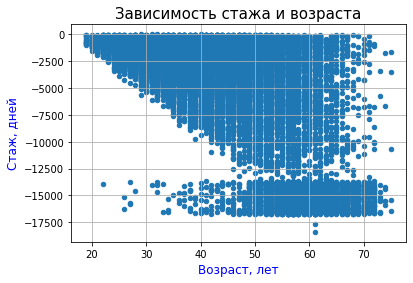

In [35]:
# строим scatter-график
df.plot.scatter(x='age_in_years', y='days_employed')
plt.title('Зависимость стажа и возраста', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12, color='blue')
plt.ylabel('Стаж, дней', fontsize=12, color='blue')
plt.grid(True)

Теперь график выглядит намного лучше! Осталась одна группа, которая не вписывается в рамки. Попробуем с ней разобраться. 

Для начала создадим новый столбец, в котором посчитаем разницу между возрастом и стажем:

In [36]:
# создаём столбец с разницей возраста и стажа
df['delta'] = df['age_in_years'] - (18 + df['days_employed'] / -365)

Теперь посчитаем количество строк, в которых стаж больше возраста.

In [37]:
# считаем количество строк где стаж больше возраста
df[df['delta'] < 0].count()

number_of_children    2122
days_employed         2122
age_in_years          2122
education_level       2122
education_level_id    2122
family_status         2122
family_status_id      2122
sex                   2122
employment_type       2122
failed_to_pay_debt    2122
monthly_income        2122
credit_purpose        2122
groups                2122
delta                 2122
dtype: int64

Заодно посмотрим на средние и крайние значения:

In [38]:
# выводим среднее, наименьшее и наибольшие значения для строк где стаж юольше возраста
df[df['delta'] < 0]['delta'].agg(['mean','min','max'])

mean    -4.643844
min    -36.451731
max     -0.000338
Name: delta, dtype: float64

Возможно в этих значениях присутствует ошибка, другой вариант &mdash; часть значений может относиться к тем, у кого стаж засчитывается с коэффициентом. С другой стороны, если стаж превышает возраст аж на 36 лет, то это аномалия.

Попробуем расправиться с этими значениями таким образом: "отзеркалим" все возможные значения, то есть сделаем стаж меньше на то же значение, на которое стаж первышал возраст. Если же стаж в таком случае окажется отрицательным, тогда просто вычтем из стажа разницу с возрастом.

In [39]:
# создаём функцию для преобразования значений находящихся за пределами допустимых
def overemployment(df):
    if (df['delta'] < 0) & (df['days_employed'] < (df['delta'] * 2 * 365)):
        return df['days_employed'] - (df['delta'] * 2 * 365)
    elif (df['delta'] < 0) & (df['days_employed'] > (df['delta'] * 2 * 365)):
        return (df['days_employed'] - (df['delta'] * 365))
    else:
        return df['days_employed']

Применим эту функцию к таблице:

In [40]:
# применяем функцию к таблице
df['days_employed'] = df.apply(overemployment, axis=1)

И взглянем на график:

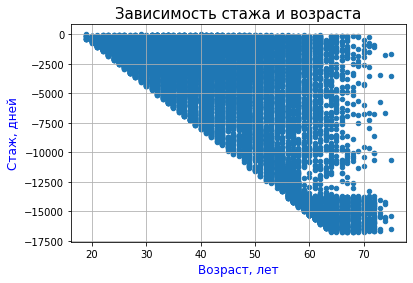

In [41]:
# строим scatter-график
df.plot.scatter(x='age_in_years', y='days_employed')
plt.title('Зависимость стажа и возраста', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12, color='blue')
plt.ylabel('Стаж, дней', fontsize=12, color='blue')
plt.grid(True)

Отлично! Мы избавились от аномальных значений, но значения трудового стажа всё ещё отрицательные. Преобразуем же значения:

In [42]:
# берём значения столбца по модулю
df['days_employed'] = df['days_employed'].abs()

Ещё раз взглянем на график:

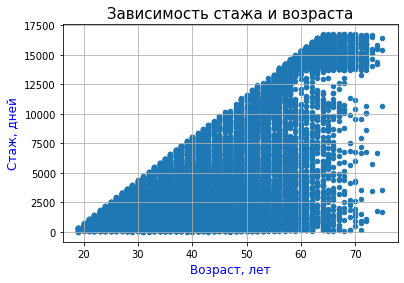

In [43]:
# строим scatter-график
df.plot.scatter(x='age_in_years', y='days_employed')
plt.title('Зависимость стажа и возраста', fontsize=15)
plt.xlabel('Возраст, лет', fontsize=12, color='blue')
plt.ylabel('Стаж, дней', fontsize=12, color='blue')
plt.grid(True)

Таким образом, мы разобрались с пропущенными значениями.

[к началу страницы](#top)

### 2.4 Изменение типа данных
<a id="2-4"></a>

Снова обратимся к общей информации по таблице:

In [44]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
number_of_children    21525 non-null int64
days_employed         21525 non-null float64
age_in_years          21525 non-null int64
education_level       21525 non-null object
education_level_id    21525 non-null int64
family_status         21525 non-null object
family_status_id      21525 non-null int64
sex                   21525 non-null object
employment_type       21525 non-null object
failed_to_pay_debt    21525 non-null int64
monthly_income        21524 non-null float64
credit_purpose        21525 non-null object
groups                21525 non-null category
delta                 21525 non-null float64
dtypes: category(1), float64(3), int64(5), object(5)
memory usage: 2.2+ MB


Избавимся от лишнего столбца `groups`:

In [45]:
# удаляем лишний столбец
df.drop('groups', axis = 1, inplace = True)

Проверяем, удалился ли столбец:

In [46]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
number_of_children    21525 non-null int64
days_employed         21525 non-null float64
age_in_years          21525 non-null int64
education_level       21525 non-null object
education_level_id    21525 non-null int64
family_status         21525 non-null object
family_status_id      21525 non-null int64
sex                   21525 non-null object
employment_type       21525 non-null object
failed_to_pay_debt    21525 non-null int64
monthly_income        21524 non-null float64
credit_purpose        21525 non-null object
delta                 21525 non-null float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.1+ MB


Отлично! Теперь взглянем на типы данных:

Возьмём столбцы с типом данных *int*:

В целом, выглядит логично, количество детей, id - всё это целые числа. Взглянем на столбец должников:

In [47]:
# посчитаем количество значений по категориям
df.groupby('failed_to_pay_debt')['failed_to_pay_debt'].count()

failed_to_pay_debt
0    19784
1     1741
Name: failed_to_pay_debt, dtype: int64

Всего два значения, которые даже по смыслу напрашиваются на замену на тип данных *boolean*. Так давайте так и сделаем:

In [48]:
# преобразуем тип данных
df['failed_to_pay_debt'] = df['failed_to_pay_debt'].astype('bool')

Посмотрим, получилось ли изменить тип данных:

In [49]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
number_of_children    21525 non-null int64
days_employed         21525 non-null float64
age_in_years          21525 non-null int64
education_level       21525 non-null object
education_level_id    21525 non-null int64
family_status         21525 non-null object
family_status_id      21525 non-null int64
sex                   21525 non-null object
employment_type       21525 non-null object
failed_to_pay_debt    21525 non-null bool
monthly_income        21524 non-null float64
credit_purpose        21525 non-null object
delta                 21525 non-null float64
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 2.0+ MB


Взглянем и на сами значения:

In [50]:
# посчитаем количество значений по категориям
df.groupby('failed_to_pay_debt')['failed_to_pay_debt'].count()

failed_to_pay_debt
False    19784
True      1741
Name: failed_to_pay_debt, dtype: int64

Тип данных изменился, теперь взглянем на столбцы с типом данных *float*:

Видно, что для дней и годов тип данных *float* не очень то и подходит, для дохода допустимо использовать *float*. К тому же у нас есть пропущенное значение **NaN**, которое не применяется в тип данных *int*. Изменим тип данных столбцов `days_employed`, `age_in_years`  на *int*:

In [51]:
# преобразуем тип данных
df['days_employed'] = df['days_employed'].astype('int')
df['age_in_years'] = df['age_in_years'].astype('int')

Посмотрим общую информацию по таблице:

In [52]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
number_of_children    21525 non-null int64
days_employed         21525 non-null int64
age_in_years          21525 non-null int64
education_level       21525 non-null object
education_level_id    21525 non-null int64
family_status         21525 non-null object
family_status_id      21525 non-null int64
sex                   21525 non-null object
employment_type       21525 non-null object
failed_to_pay_debt    21525 non-null bool
monthly_income        21524 non-null float64
credit_purpose        21525 non-null object
delta                 21525 non-null float64
dtypes: bool(1), float64(2), int64(5), object(5)
memory usage: 2.0+ MB


На этом мы заканчиваем преобразование типов данных и переходим к лемматизации и категорированию.

### 2.5 Лемматизация данных
<a id="2-5"></a>

Нам необходимо сгруппировать различные цели получения кредита для более наглядного восприятия данных. Посмотрим сколько на текущий момент содержится в таблице различных целей получения кредита:

In [53]:
df.groupby('credit_purpose')['credit_purpose'].count().count() # считаем количество категорий

38

Целых 38 целей! Давайте посмотрим с какими же целями клиенты обращаются за дополнительным финансированием в банк:

In [54]:
df.groupby('credit_purpose')['credit_purpose'].count() # выводим на экран список категорий

credit_purpose
автомобили                                478
автомобиль                                495
высшее образование                        453
дополнительное образование                462
жилье                                     647
заняться высшим образованием              496
заняться образованием                     412
на покупку автомобиля                     472
на покупку подержанного автомобиля        479
на покупку своего автомобиля              505
на проведение свадьбы                     777
недвижимость                              634
образование                               447
операции с жильем                         653
операции с коммерческой недвижимостью     651
операции с недвижимостью                  676
операции со своей недвижимостью           630
покупка жилой недвижимости                607
покупка жилья                             647
покупка жилья для сдачи                   653
покупка жилья для семьи                   641
покупка коммерческо

Оказывается не так уж и разнообразны предпочтения у клиентов банка. 38 разных формулировок похожих запросов. Попробуем сократить категории с помощью лемматизации:

In [55]:
# сохраняем столбец с категориями в переменной purpose
purpose = df.groupby('credit_purpose')['credit_purpose'].count()
# создаём пустой список cats
cats = []
# склеиваем все категории в 1 список
for i, v in purpose.iteritems():
    cats.append(i)
# считаем леммы в получившемся списке    
Counter(m.lemmatize(' '.join(cats))).most_common()

[(' ', 96),
 ('покупка', 10),
 ('недвижимость', 10),
 ('автомобиль', 9),
 ('образование', 9),
 ('жилье', 7),
 ('с', 5),
 ('на', 4),
 ('свой', 4),
 ('операция', 4),
 ('высокий', 3),
 ('свадьба', 3),
 ('получение', 3),
 ('строительство', 3),
 ('дополнительный', 2),
 ('заниматься', 2),
 ('подержать', 2),
 ('коммерческий', 2),
 ('жилой', 2),
 ('для', 2),
 ('сделка', 2),
 ('проведение', 1),
 ('со', 1),
 ('сдача', 1),
 ('семья', 1),
 ('приобретение', 1),
 ('профильный', 1),
 ('ремонт', 1),
 ('собственный', 1),
 ('сыграть', 1),
 ('\n', 1)]

В итоге у нас остаётся всего 4 уникальные категории (и одна подобная по смыслу):

- недвижимость (жилье) 
- автомобиль
- образование
- свадьба

Создадим словарь для обобщения 38 целей кредита в 4 категории:

In [56]:
# создадим пустой словарь
dict = {}
# для каждой категории подберём обобщение
for i, v in purpose.iteritems():
    if 'недвижимость' in m.lemmatize(i) or 'жилье' in m.lemmatize(i):
        dict[i] = 'недвижимость'
    elif 'автомобиль' in m.lemmatize(i):
        dict[i] = 'автомобиль'
    elif 'образование' in m.lemmatize(i):
        dict[i] = 'образование'
    elif 'свадьба' in m.lemmatize(i):
        dict[i] = 'свадьба'
    else:
        dict[i] = 'прочее'
# выведем словарь на экран
print(dict)

{'автомобили': 'автомобиль', 'автомобиль': 'автомобиль', 'высшее образование': 'образование', 'дополнительное образование': 'образование', 'жилье': 'недвижимость', 'заняться высшим образованием': 'образование', 'заняться образованием': 'образование', 'на покупку автомобиля': 'автомобиль', 'на покупку подержанного автомобиля': 'автомобиль', 'на покупку своего автомобиля': 'автомобиль', 'на проведение свадьбы': 'свадьба', 'недвижимость': 'недвижимость', 'образование': 'образование', 'операции с жильем': 'недвижимость', 'операции с коммерческой недвижимостью': 'недвижимость', 'операции с недвижимостью': 'недвижимость', 'операции со своей недвижимостью': 'недвижимость', 'покупка жилой недвижимости': 'недвижимость', 'покупка жилья': 'недвижимость', 'покупка жилья для сдачи': 'недвижимость', 'покупка жилья для семьи': 'недвижимость', 'покупка коммерческой недвижимости': 'недвижимость', 'покупка недвижимости': 'недвижимость', 'покупка своего жилья': 'недвижимость', 'получение высшего образова

Заменим на основе получившегося словаря столбец `credit_purpose`:

In [57]:
# заменим значения в столбце 'credit_purpose' на основании словаря
df.replace(to_replace = dict, value = None, inplace = True)

Взглянем снова на этот столбец:

In [58]:
# сгруппирруем по категориям
df.groupby('credit_purpose').count()

,number_of_children,days_employed,age_in_years,education_level,education_level_id,family_status,family_status_id,sex,employment_type,failed_to_pay_debt,monthly_income,delta
credit_purpose,,,,,,,,,,,,
автомобиль,4315,4315,4315,4315,4315,4315,4315,4315,4315,4315,4315,4315
недвижимость,10840,10840,10840,10840,10840,10840,10840,10840,10840,10840,10839,10840
образование,4022,4022,4022,4022,4022,4022,4022,4022,4022,4022,4022,4022
свадьба,2348,2348,2348,2348,2348,2348,2348,2348,2348,2348,2348,2348


Таким образом мы лемматизировали и категорировали данные по столбцу `credit_purpose`. Теперь займемся категорированием и других столбцов.

### 2.6 Категорирование данных
<a id="2-6"></a>

В таблице есть две пары столбцов которые относят клиентов банка к какой-либо категории: `education_level`/`education_level_id` и `family_status`/`family_status_id`. Мы спокойно можем избавиться от столбцов значений и оставить только столбцы с ключами (*id*).

Для уровня образования создадим словарь в переменной `education_dict`:

In [59]:
# добавим в переменную education_dict столбцы 'education_level' и 'education_level_id' из основной таблицы
education_dict = df[['education_level_id', 'education_level']]
# избавимся от дубликатов
education_dict = education_dict.drop_duplicates().reset_index(drop = True)
# выведем словарь на экран
education_dict

,education_level_id,education_level
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Теперь сделаем такой же словарь для семейного положения:

In [60]:
# добавим в переменную family_status_dict столбцы 'family_status' и 'family_status_id' из основной таблицы
family_status_dict = df[['family_status_id', 'family_status']]
# избавимся от дубликатов
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop = True)
# выведем словарь на экран
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


Теперь уберём столбцы с названиями этих категорий из основной таблицы:

In [61]:
# уберём из основной таблицы названия категорий по уровню образования и семейному положению
df = df[['number_of_children', 'days_employed', 'age_in_years', 'education_level_id', 'family_status_id', 'sex', 'employment_type', 'failed_to_pay_debt', 'monthly_income', 'credit_purpose']]

Взглянем на информацию о таблице:

In [62]:
df.info() # получим общую информацию о таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
number_of_children    21525 non-null int64
days_employed         21525 non-null int64
age_in_years          21525 non-null int64
education_level_id    21525 non-null int64
family_status_id      21525 non-null int64
sex                   21525 non-null object
employment_type       21525 non-null object
failed_to_pay_debt    21525 non-null bool
monthly_income        21524 non-null float64
credit_purpose        21525 non-null object
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 1.5+ MB


Кроме этих столбцов у нас есть еще два столбца, которые можно категорировать. Например, по количеству детей можно выделить категории бездетных (0 детей), малодетных (от 0 до 3 детей) и многодетных (3 и более детей). Для этого опишем специальную функцию:

In [63]:
# определим функцию для категоризации в зависимости от количества детей
def children_categorizer(row):
    if row['number_of_children'] == 0:
        return 0
    elif (row['number_of_children'] > 0) and (row['number_of_children'] < 3):
        return 1
    elif (row['number_of_children'] >= 3):
        return 2

Теперь применим эту функцию к таблице и сохраним результат в отдельный столбец `number_of_children_id`:

In [64]:
# применим функцию к таблице и сохраним результат в новый столбец
df['number_of_children_id'] = df.apply(children_categorizer, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Проверим, получилось ли создать новый столбец. Выведем на экран сгруппированную по категориям сводку:

In [65]:
# выведем на экран новые категории
df.groupby('number_of_children_id')['number_of_children_id'].count()

number_of_children_id
0    14272
1     6873
2      380
Name: number_of_children_id, dtype: int64

Теперь, чтобы понять что обозначают id из нового столбца, создадим словарь:

In [66]:
# создадим таблицу-словарь
number_of_children_dict = pd.DataFrame.from_dict({
    'number_of_children_id': [0, 1, 2], 
    'number_of_children_type': ['бездетный(ая)', 'малодетный(ая)', 'многодетный(ая)']
})
# и выведем её на экран
number_of_children_dict

,number_of_children_id,number_of_children_type
0,0,бездетный(ая)
1,1,малодетный(ая)
2,2,многодетный(ая)


Также мы можем провести категорирование по столбцу `monthly_income`. В первом варианте используем квантили для стандартного нормального распределения:

In [67]:
# присвоим переменным q0-q5 значения, характерные для нормального распределения
q0 = df['monthly_income'].min()
q1 = df['monthly_income'].quantile(q=0.025)
q2 = df['monthly_income'].quantile(q=0.16)
q3 = df['monthly_income'].quantile(q=0.84)
q4 = df['monthly_income'].quantile(q=0.975)
q5 = df['monthly_income'].max()

На основе квантилей разобьём всех клиентов на 5 групп:

In [68]:
# создадим сводную таблицу и разделим на промежутки
df['income_groups'] = pd.cut(df['monthly_income'], [q0, q1, q2, q3, q4, q5], include_lowest = True)
# посчитаем количество значений и среднее по указанным промежуткам
df.groupby('income_groups')['monthly_income'].agg(['count','mean','median','min','max'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count,mean,median,min,max
income_groups,,,,,
"(20667.263, 54214.429]",539,45083.317611,47395.440364,20667.263793,5.421382e+04
"(54214.429, 90939.015]",2905,75403.119554,76935.177494,54221.913003,9.093789e+04
"(90939.015, 232667.162]",14636,149418.995672,144881.784198,90939.542659,2.326626e+05
"(232667.162, 398549.838]",2905,287228.823817,276232.574400,232676.916792,3.980370e+05
"(398549.838, 2265604.029]",539,546324.342386,477983.633851,398591.419329,2.265604e+06


Определим функцию для категорирования клиентов:

In [69]:
# определим функцию, которая возвращает id группы на основании значения ежемесячного дохода
def income_categorizer(row):
    if row['monthly_income'] < q1:
        return 0
    elif (row['monthly_income'] >= q1) and (row['monthly_income'] < q2):
        return 1
    elif (row['monthly_income'] >= q2) and (row['monthly_income'] < q3):
        return 2
    elif (row['monthly_income'] >= q3) and (row['monthly_income'] < q4):
        return 3
    elif (row['monthly_income'] >= q4):
        return 4
    else:
        return 5

Применим функцию к таблице и сохраним результат в столбце `monthly_income_id`:

In [70]:
# присваиваем столбцу результат применения функции к таблице
df['monthly_income_id'] = df.apply(income_categorizer, axis = 1)

Проверим, получилось ли создать новый столбец. Выведем на экран сгруппированную по категориям сводку:

In [71]:
# выведем на экран результат присвоения новых id
df.groupby('monthly_income_id')['monthly_income_id'].count()

monthly_income_id
0      539
1     2905
2    14636
3     2905
4      539
5        1
Name: monthly_income_id, dtype: int64

Создадим словарь, сохраним в переменной `monthly_income_dict` и выведем его на экран:

In [72]:
# создадим таблицу-словарь
monthly_income_dict = pd.DataFrame.from_dict({
    'monthly_income_id': [0, 1, 2, 3, 4, 5], 
    'monthly_income_type': ['низкий', 'ниже среднего', 'средний', 'выше среднего', 'высокий', 'неизвестно']
})
# и выведем её на экран
monthly_income_dict

,monthly_income_id,monthly_income_type
0,0,низкий
1,1,ниже среднего
2,2,средний
3,3,выше среднего
4,4,высокий
5,5,неизвестно


Это не единственный вариант категорирования по доходу. Можем, например воспользоваться [моделью](https://isp.hse.ru/data/2019/10/04/1541835897/03%20Natalia%20Tikhinova_03-10-2019_RU.pdf) доходной стратификации массовых слоев российского общества, и взять показатели для основных групп:

In [73]:
# найдём медианное значение дохода
p_median = df['monthly_income'].median()
# присвоим переменным p0-p7 значения границ групп относительно медианы
p0 = df['monthly_income'].min()
p1 = p_median * 0.25
p2 = p_median * 0.5
p3 = p_median * 0.75
p4 = p_median * 1.25
p5 = p_median * 2
p6 = p_median * 4
p7 = df['monthly_income'].max()

Также создадим сводную таблицу:

In [74]:
# создадим сводную таблицу и разделим на промежутки
df['income_strats'] = pd.cut(df['monthly_income'], [p0, p1, p2, p3, p4, p5, p6, p7], include_lowest = True)
# посчитаем количество значений и среднее по указанным промежуткам
df.groupby('income_strats')['monthly_income'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
income_strats,,,,,
"(20667.263, 36220.446]",77,31191.557304,32329.183971,20667.263793,3.608049e+04
"(36220.446, 72440.892]",1581,59389.495605,61416.476816,36260.320487,7.243994e+04
"(72440.892, 108661.338]",3837,91729.331266,92118.679313,72448.508178,1.086451e+05
"(108661.338, 181102.23]",9259,141070.883439,140633.996300,108662.711954,1.810982e+05
"(181102.23, 289763.568]",5108,222380.006795,216956.399209,181109.922091,2.897556e+05
"(289763.568, 579527.137]",1536,367824.721732,347632.422621,289851.239252,5.790051e+05
"(579527.137, 2265604.029]",126,823633.343734,694093.559357,579594.432759,2.265604e+06


Опишем функцию для такого варианта категорирования:

In [75]:
# определим функцию, которая возвращает id страты на основании значения ежемесячного дохода
def income_stratificator(row):
    if row['monthly_income'] < p1:
        return 0
    elif (row['monthly_income'] >= p1) and (row['monthly_income'] < p2):
        return 1
    elif (row['monthly_income'] >= p2) and (row['monthly_income'] < p3):
        return 2
    elif (row['monthly_income'] >= p3) and (row['monthly_income'] < p4):
        return 3
    elif (row['monthly_income'] >= p4) and (row['monthly_income'] < p5):
        return 4
    elif (row['monthly_income'] >= p5) and (row['monthly_income'] < p6):
        return 5
    elif (row['monthly_income'] >= p6):
        return 6
    else:
        return 7

Применим функцию к таблице и сохраним результат в столбец `income_strat_id`:

In [76]:
# присваиваем столбцу результат применения функции к таблице
df['income_strat_id'] = df.apply(income_stratificator, axis = 1)

Выведем новый вариант категорирования на экран:

In [77]:
# выведем на экран результат присвоения новых id
df.groupby('income_strat_id')['income_strat_id'].count()

income_strat_id
0      77
1    1581
2    3837
3    9259
4    5108
5    1536
6     126
7       1
Name: income_strat_id, dtype: int64

Создадим под новую классификацию словарь:

In [78]:
# создадим таблицу-словарь
income_strat_dict = pd.DataFrame.from_dict({
    'income_strat_id': [0, 1, 2, 3, 4, 5, 6, 7], 
    'income_strat_type': ['нищие', 'нуждающиеся', 'бедные', 'медианная группа', 'среднедоходные', 'обеспеченные', 'состоятельные', 'неизвестно']
})
# и выведем её на экран
income_strat_dict

,income_strat_id,income_strat_type
0,0,нищие
1,1,нуждающиеся
2,2,бедные
3,3,медианная группа
4,4,среднедоходные
5,5,обеспеченные
6,6,состоятельные
7,7,неизвестно


Отлично! Теперь можно двигаться дальше.

### 2.7 Выводы
<a id="2-7"></a>

На этапе предобработки в данных обнаружились проблемы с названиями столбцов, пропуски и дубликаты. Их удаление позволит провести анализ точнее. Поскольку сведения важно сохранить для анализа, мы не удаляли все пропущенные значения, а заполнили пропущенный месячный доход и трудовой стаж. Имена столбцов теперь корректны и удобны для дальнейшей работы. Также, мы провели категорирование по столбцам с количеством детей и с ежемесячным доходом. Вывели дублирующиеся столбцы в словари, а столбец с целью кредита лемматизировали и категорировали.

[к началу раздела](#2) | [к началу страницы](#top)

## 3. Проверка гипотез
<a id="3"></a>

Теперь нам необходимо использовать предобработанные данные для ответа на следующие вопросы:
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

Для начала оценим среднюю вероятность невозврата кредита в срок для всех клиентов:

In [79]:
# выведем на экран строку и отформатируем среднее по столбцу `failed_to_pay_debt` в процентах с двумя знаками после запятой
print('Средняя вероятность невозврата кредита в срок: {:.2%}'.format(df['failed_to_pay_debt'].mean()))

Средняя вероятность невозврата кредита в срок: 8.09%


Теперь посмотрим как зависит вероятность невозврата кредита в срок от различных параметров.

### 3.1 Как влияет наличие детей на возврат кредита в срок?
<a id="3-1"></a>

Мы уже разделили клиентов на три категории в зависимости от количества детей. Теперь посмотрим какая вероятность невозврата кредита в срок для каждой из категорий:

In [80]:
# создаём сводную таблицу и сохраняем её в переменную
children_guess = df.groupby('number_of_children_id')['failed_to_pay_debt'].agg(['count', 'mean'])
# добавляем столбец с названиями групп
children_guess['number_of_children_type'] = number_of_children_dict['number_of_children_type']
# сортируем значения в порядке убывания
children_guess.sort_values(by = ['mean'], ascending = False)

,count,mean,number_of_children_type
number_of_children_id,,,
1,6873,0.092827,малодетный(ая)
2,380,0.081579,многодетный(ая)
0,14272,0.075112,бездетный(ая)


Как видим, клиенты с детьми в среднем не возвращают долг в срок чаще, чем бездетные. При этом вероятность невозврата и для малодетных и для многодетных клиентов выше средней.

Рассмотрим ситуацию по конкретному количеству детей, а не по группам:

In [81]:
# создаём сводную таблицу и сортируем в порядке убывания
df.groupby('number_of_children')['failed_to_pay_debt'].agg(['count', 'mean']).sort_values(by = ['mean'], ascending = False)

,count,mean
number_of_children,,
4,41,0.097561
2,2055,0.094404
1,4818,0.092154
3,330,0.081818
0,14272,0.075112
5,9,0.000000


Кроме того, построим график для наглядности:

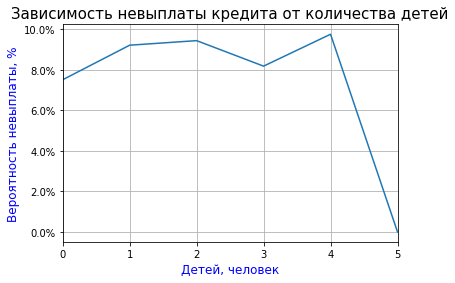

In [82]:
# строим график на основании сводной таблицы
ax = df.groupby('number_of_children')['failed_to_pay_debt'].agg(['mean']).plot()
plt.title('Зависимость невыплаты кредита от количества детей', fontsize=15)
plt.xlabel('Детей, человек', fontsize=12, color='blue')
plt.ylabel('Вероятность невыплаты, %', fontsize=12, color='blue')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.legend().remove()

Как видим, ситуация практически не поменялась: почти все клиенты с детьми не возвращали долг в срок чаще, чем в среднем по всем клиентам. Но есть уникальная группа из 9 клиентов с 5ю детьми: они расплатились в срок в 100% случаев. К сожалению, такого количества наблюдений недостаточно, чтобы сказать что 5 детей благотврно влияют на способность расплатиться в срок. Кроме того, появилась и другая группа из 41 клиента с 4-мя детми с наиболее высоким процентом невозврата кредита. Опять же, количество клиентов с 4 детьми является слишком маленьким чтобы однозначно говорить о негативном влиянии конкретно 4 детей на кредитоспособность клиента.

#### Вывод

В целом можно сказать, что клиенты без детей скорее оплатят кредит в срок, чем клиенты с детьми. При этом клиенты без детей &mdash; единственная группа, которая возвращает долг с вероятностью выше средней. Так же можно с большей погрешностью сказать, что клиенты у которых 1-2 ребёнка с меньшей вероятностью вернут кредит в срок, чем клиенты с 3 и более детьми.

### 3.2 С какой веротностью вернут кредит в срок клиенты с разным семейным положением?
<a id="3-2"></a>

Теперь оценим зависимость возврата кредита в срок от семейного положения клиента.

Построим сводную таблицу:

In [83]:
# создаём сводную таблицу и сохраняем её в переменную
family_guess = df.groupby('family_status_id')['failed_to_pay_debt'].agg(['count', 'mean'])
# добавляем столбец с названиями групп
family_guess['family_status'] = family_status_dict['family_status']
# сортируем значения в порядке убывания
family_guess.sort_values(by = ['mean'], ascending = False)

,count,mean,family_status
family_status_id,,,
4,2813,0.097405,не женат / не замужем
1,4177,0.092890,гражданский брак
0,12380,0.075202,женат / замужем
3,1195,0.071130,в разводе
2,960,0.065625,вдовец / вдова


#### Вывод

Видим, что те клиенты, которые не состояли в брачных отношениях или не зарегистрировали их официально показывают вероятность не расплатиться в срок выше средней. Клиенты, состоящие или состоявшие в браке, показывают повышенную относительно средней вероятность вернуть кредит вовремя. При этом вдовцы и вдовы оказались надёжнее разведённых клиентов, а они, в свою очередь, надёжнее клиентов, состоящих в браке.

### 3.3 Кто вероятнее расплатится в срок - бедный или богатый?
<a id="3-3"></a>

Проверим, как зависит вероятность расплатится в срок от дохода клиента в месяц. Посмотрим на сводную таблицу по группам по уровню дохода:

In [84]:
# создаём сводную таблицу и сохраняем её в переменную
monthly_income_guess = df.groupby('monthly_income_id')['failed_to_pay_debt'].agg(['count', 'mean'])
# добавляем столбец с названиями групп
monthly_income_guess['monthly_income_type'] = monthly_income_dict['monthly_income_type']
# сортируем значения в порядке убывания, убираем строку с отсутствующим доходом
monthly_income_guess.sort_values(by = ['mean'], ascending = False).drop([5])

,count,mean,monthly_income_type
monthly_income_id,,,
2,14636,0.084244,средний
1,2905,0.081583,ниже среднего
3,2905,0.070568,выше среднего
0,539,0.063080,низкий
4,539,0.059369,высокий


Также построим график:

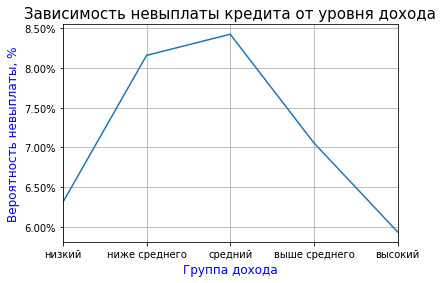

In [85]:
# строим график на основании сводной таблицы
ax = monthly_income_guess['mean'].drop([5]).plot()
plt.title('Зависимость невыплаты кредита от уровня дохода', fontsize=15)
plt.xlabel('Группа дохода', fontsize=12, color='blue')
plt.xticks(ticks = [0, 1, 2, 3, 4], labels = ['низкий', 'ниже среднего', 'средний', 'выше среднего', 'высокий'])
plt.ylabel('Вероятность невыплаты, %', fontsize=12, color='blue')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.legend().remove()

Видим, что ближе к среднему уровню дохода увеличивается вероятность невыплаты кредита в срок. При этом при среднем доходе и доходе ниже среднего вероятность невыплаты оказывается выше средней.

Взглянем и на другой вариант распределения:

In [86]:
# создаём сводную таблицу и сохраняем её в переменную
income_strat_guess = df.groupby('income_strat_id')['failed_to_pay_debt'].agg(['count', 'mean'])
# добавляем столбец с названиями групп
income_strat_guess['income_strat_type'] = income_strat_dict['income_strat_type']
# сортируем значения в порядке убывания, убираем строку с отсутствующим доходом
income_strat_guess.sort_values(by = ['mean'], ascending = False).drop([7])

,count,mean,income_strat_type
income_strat_id,,,
3,9259,0.087158,медианная группа
2,3837,0.084180,бедные
4,5108,0.073806,среднедоходные
5,1536,0.072917,обеспеченные
1,1581,0.069576,нуждающиеся
6,126,0.063492,состоятельные
0,77,0.051948,нищие


И на график этого распределения:

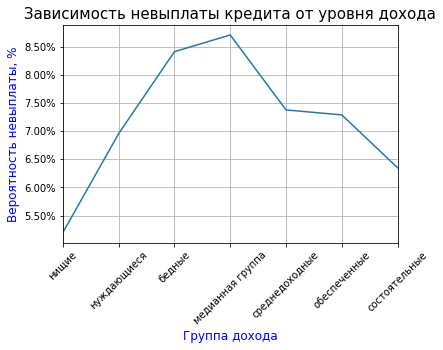

In [87]:
# строим график на основании сводной таблицы
ax = df.groupby('income_strat_id')['failed_to_pay_debt'].agg(['mean']).drop([7]).plot()
plt.title('Зависимость невыплаты кредита от уровня дохода', fontsize=15)
plt.xlabel('Группа дохода', fontsize=12, color='blue')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = ['нищие', 'нуждающиеся', 'бедные', 'медианная группа', 'среднедоходные', 'обеспеченные', 'состоятельные'], rotation=45)
plt.ylabel('Вероятность невыплаты, %', fontsize=12, color='blue')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.legend().remove()

Видим аналогичную картину: ближе к средним доходам вероятность невыплаты увеличивается, на краях выше вероятнсоть расплатиться в срок. Аналогично, группа с медианным доходом и группа на уровень ниже оказались с вероятностью не расплатиться выше средней.

#### Вывод

Оказалось, что наименее надёжными оказались клиенты со средними доходами, следом за ними идут клиенты с доходами ниже среднего. При этом дальше вероятность возврата кредита оказалась зеркальной: как бедные, так и богатые люди возвращают долги в срок примерно с одинаковой вероятностью &mdash; и эта вероятность выше средней.

### 3.4 Свадьба или образование? Автомобиль или недвижимость? Где риски невозврата кредита выше?
<a id="3-4"></a>

Ответим теперь на последний вопрос: как связаны цели кредита и вероятность его возврата в срок?

Построим сводную таблицу:

In [88]:
# создаём сводную таблицу и сортируем в порядке убывания
df.groupby('credit_purpose')['failed_to_pay_debt'].agg(['count', 'mean']).sort_values(by = ['mean'], ascending = False)

,count,mean
credit_purpose,,
автомобиль,4315,0.093395
образование,4022,0.091994
свадьба,2348,0.079216
недвижимость,10840,0.072140


#### Вывод

Из таблицы следует, что когда целью кредита выступает автомобиль или образование, риск невозврата кредита в срок возрастает и оказывается выше среднего. При этом, если кредит приобретается для свадьбы или недвижимости, риски наоборот ниже средних.

[к началу раздела](#3) | [к началу страницы](#top)

## Этап 4. Результаты исследования
<a id="4"></a>

### 4.1 Общие выводы
<a id="4-1"></a>

В этом исследовании нас интересовали ответы на следующие вопросы:
- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

#### Общие результаты

Все эти параметры так или иначе связаны с вероятностью невозвращения кредита в срок. При этом не обязательно прямое влияние этих признаков, возможно наличие другого параметра, скрытого, но влияющего и на вероятность возврата кредита и на какой-то из вышеуказанных параметров.

При этом можно сказать, что зависимости проявляют себя: ни по одному параметру не было отклонения меньше 1%, не было параметров, по которым между категориями не было различий.

Основываясь на результатах исследования, можно сказать, что профиль наиболее рискового клиента: малодетный, не состоящий в браке, со средним доходом, хочет купить автомобиль или оплатить учёбу. Наличие таких признаков не значит, что нужно обязательно отказывать в кредите, однако стоит рассмотреть изменение условий для такого рода клиентов.

Кроме того, результаты этого исследования целесообразно учесть при составлении скоринговой модели для оценки кредитоспособности клиентов банка.

[к началу раздела](#4) | [к началу страницы](#top)